In [2]:
from tqdm.auto import trange

import numpy as np
import plotly.graph_objects as go

import torch
from torch.utils.data import DataLoader

import os
import sys
import datetime

from IPython.display import SVG, display

def imshow(fig):
    return display(SVG(fig.to_image(format="svg")))

%matplotlib inline
%config InlineBackend.figure_format='retina'

eps = 1e-10  # A negligible positive number
np.random.seed(0)

In [3]:
"""The code below is used to set up customized training device on computer"""
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("You are using GPU acceleration.")
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Number of CUDAs(cores): ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("CUDA is not Available. You are using CPU only.")
    print("Number of cores: ", os.cpu_count())

You are using GPU acceleration.
Device name:  NVIDIA GeForce RTX 2080 Ti
Number of CUDAs(cores):  8


In [4]:
%cd /tmp/pycharm_project_300
from src.data.data import TPPWrapper, pad_collate
from src.models.model import AutoIntTPPSameInfluence

/tmp/pycharm_project_300


In [16]:
dataset = TPPWrapper(lamb_func, n_sample=8192, t_end=1000.0, max_lamb=50, verbose=True)

  0%|          | 0/8192 [00:00<?, ?it/s]

Generating events from t=0 to t=1000.0
----
t:  3.9793725408155503
λt: 0.2
----
t:  8.595488269835894
λt: 0.21797884412709975
----
t:  11.101497534403054
λt: 0.22063439520451508
----
t:  13.291359044242387
λt: 0.24689456317152064
----
t:  23.750847261710817
λt: 0.20127090016340135
----
t:  27.485427605203633
λt: 0.20547822226829698
----
t:  37.583996721565654
λt: 0.20054015880163487
----
t:  37.68537317351803
λt: 0.5798308198165583
----
t:  56.66029607065788
λt: 0.20005870127436995
----
t:  64.24185100087809
λt: 0.20573135640933304
----
t:  69.23623039628565
λt: 0.22178788913292802
----
t:  81.89946885188346
λt: 0.20075143509128568
----
t:  83.43291274168385
λt: 0.29655832806970434
----
t:  85.51108321810413
λt: 0.23995127174702102
----
t:  85.5735440670964
λt: 0.6233270304000904
----
t:  87.48918545469115
λt: 0.3276496812124524
----
t:  98.83614484630942
λt: 0.20186291476256213
----
t:  101.68970300609288
λt: 0.2022002472196872
----
t:  101.93982736792951
λt: 0.5476904799905739
----
t

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



KeyboardInterrupt: 

In [6]:
def lamb_func(t, his_t):
    alpha = .2
    beta = .5
    mu = .2
    delta_t = t - his_t[his_t < t]
    lamb_t = mu + alpha * np.sum((np.cos(delta_t) + 1) * np.exp(-beta * (delta_t)))
    L = 2 / lamb_t
    M = mu + alpha * np.sum(np.exp(-beta * (delta_t)))
    return (lamb_t, L, M)

dataset = TPPWrapper(lamb_func, n_sample=8192, t_end=1000.0, max_lamb=50)
dataset.save('data/temporal/anotherShakyHawkes')

  0%|          | 0/8192 [00:00<?, ?it/s]

In [7]:
trainset = TPPWrapper(lamb_func, n_sample=4096, t_end=50.0, max_lamb=50, fn='data/temporal/anotherShakyHawkes.db')
trainloader = DataLoader(trainset, shuffle=True, batch_size=64, collate_fn=pad_collate)
valset = TPPWrapper(lamb_func, n_sample=2048, n_start=4096, t_end=50.0, max_lamb=50, fn='data/temporal/anotherShakyHawkes.db')
valloader = DataLoader(valset, shuffle=False, batch_size=64, collate_fn=pad_collate)
testset = TPPWrapper(lamb_func, n_sample=2048, n_start=6144, t_end=50.0, max_lamb=50, fn='data/temporal/anotherShakyHawkes.db')
testloader = DataLoader(testset, shuffle=False, batch_size=64, collate_fn=pad_collate)

In [8]:
model = AutoIntTPPSameInfluence(hidden_size=32, t_end=50.0, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)
train_losses = []
val_losses = []

time_now = str(datetime.datetime.now())
parent_dir = f'models/AutoInt-TPP-Same-Influence-{time_now}'
os.mkdir(parent_dir)

for epoch in trange(5):
    train_loss = []
    train_like = []

    for i, (seq_pads, seq_lens, _) in enumerate(trainloader):
        optimizer.zero_grad()
        
        seq_pads = seq_pads.float().to(device)
        
        # Compute loss
        nll = model(seq_pads, seq_lens)
        loss = nll
        
        # Perform backward pass
        loss.backward()
        
        # Perform optimization
        optimizer.step()

        # Project to feasible set
        model.project()
        
        # Print statistics
        train_loss.append(loss.item())
        train_like.append(nll.item())
        
    train_losses.append(sum(train_loss) / len(train_loss))
    
    print(f'Epoch {epoch} \t trainloss: {train_losses[-1]}' + 
          f'\t nll: {sum(train_like) / len(train_like)}', file=sys.stderr)
    
    scheduler.step()
    
    # Validate the model
    if (epoch + 1) % 10 == 0:
        model.eval()
        
        val_loss = []
        val_like = []
        
        for (seq_pads, seq_lens, _) in valloader:
            seq_pads = seq_pads.float().to(device)
            
            nll = model(seq_pads, seq_lens)
            loss = nll

            val_loss.append(loss.item())
            val_like.append(nll.item())
            
        val_losses.append(sum(val_loss) / len(val_loss))
        
        print(f'Epoch {epoch} \t valloss: {val_losses[-1]}' +
              f'\t nll: {sum(val_like) / len(val_like)}', file=sys.stderr)
        
        model.train()
    
    
    # Save the model
    if (epoch + 1) % 100 == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': train_losses,
            'val_loss': val_losses,
        }, f'{parent_dir}/NTPP-{epoch}.mod')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0 	 trainloss: 39.84138086438179	 nll: 39.84138086438179
Epoch 1 	 trainloss: 29.59473031759262	 nll: 29.59473031759262
Epoch 2 	 trainloss: 29.08167764544487	 nll: 29.08167764544487
Epoch 3 	 trainloss: 29.07530164718628	 nll: 29.07530164718628
Epoch 4 	 trainloss: 29.066142708063126	 nll: 29.066142708063126


In [6]:
model = AutoIntTPPSameInfluence(hidden_size=32, t_end=50, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)
##### Load saved model #####
checkpoint = torch.load(f'model/AutoInt-TPP-Same-Influence-2021-10-02 00:55:28.136108/NTPP-99.mod')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
train_losses = checkpoint['train_loss']
val_losses = checkpoint['val_loss']
##### Load saved model #####

In [9]:
fig = go.Figure()
fig.add_trace(go.Scatter(y=train_losses, mode='lines', name='train',  marker_size=4))
fig.add_trace(go.Scatter(x=np.arange(9, 100, 10), y=val_losses[:10], mode='lines', 
                         name='val', marker_size=4))

fig.update_layout(
    title=r"Training progress",
    xaxis_title="x",
    yaxis_title="f",
)
fig.show()

In [10]:
model.eval()

AutoIntTPPSameInfluence(
  (F): MultSequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [11]:
from src.utils import *

In [13]:
'''
Compute model intensity

his_t: np array [seqlen,]
x: np array [N,]
'''
def predict(model, his_t, x):
    def lamb_func(t, his_t):
        delta_t = t - his_t[his_t < t]
        if len(delta_t) == 0:
            return model.background.item()
        lamb_t = model.F.dforward(torch.tensor(delta_t).float().unsqueeze(-1).to(device), 
                                  0).sum() + model.background
        return lamb_t.item()
    
    y = np.array([lamb_func(t, his_t) for t in x])
    return y

In [14]:
evaluate(lamb_func, predict, model, testset.seqs)

  0%|          | 0/2048 [00:00<?, ?it/s]

KeyboardInterrupt: 

ground truth: -25.21923432786735
predict: -23.830261217061203
λ MAPE: 0.1288425565536907


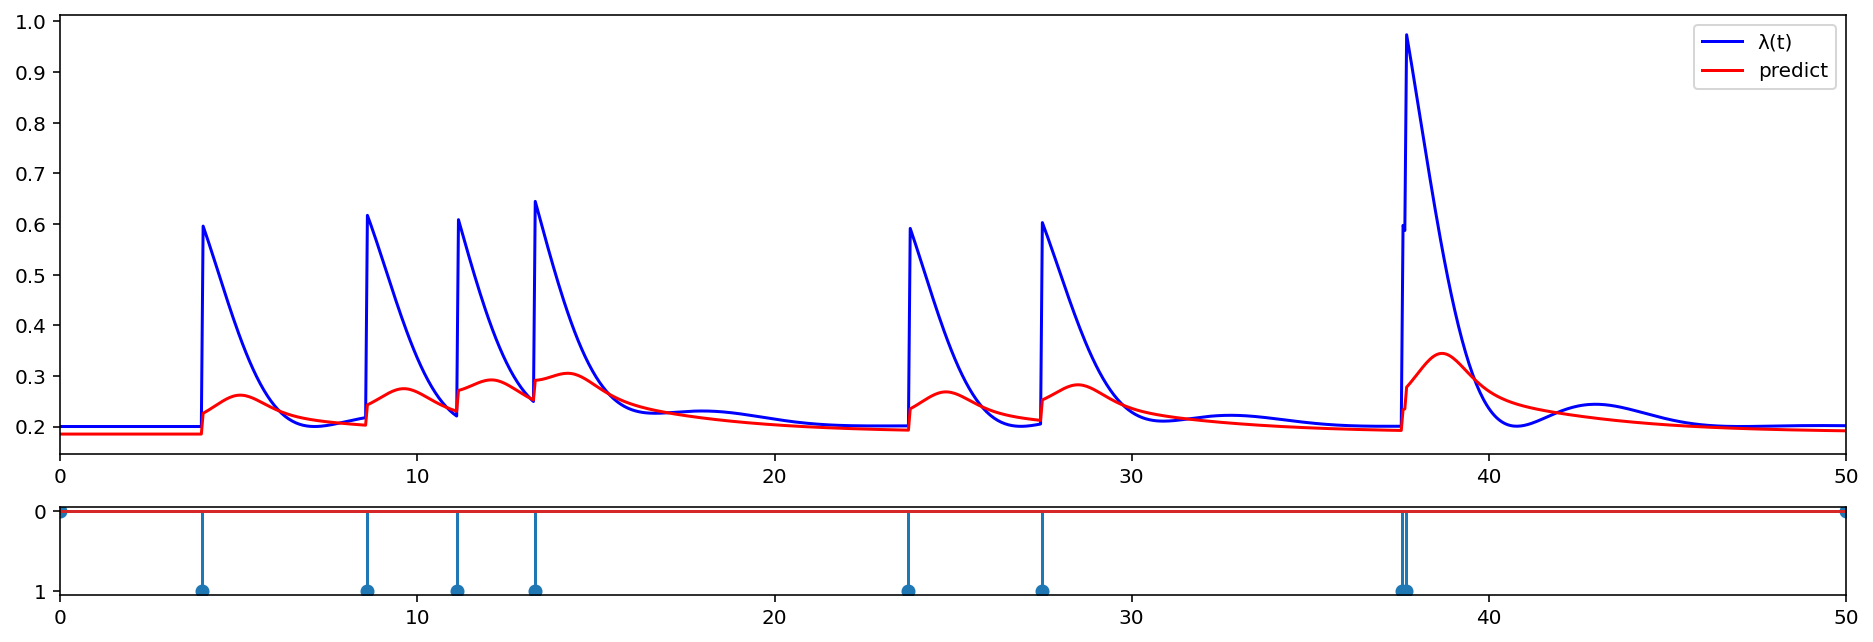

In [15]:
plot_predict_intensity(lamb_func, predict, model, trainset.seqs[0].numpy())